In [3]:
import numpy as np
import matplotlib.pyplot as plt


SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc('font', family='Roboto')           # controls default font
plt.rc('font', weight='normal')              # controls default font
plt.rc('font', size=SIZE_DEFAULT)       # controls default text sizes
plt.rc('axes', titlesize=SIZE_LARGE)    # fontsize of the axes title
plt.rc('axes', labelsize=SIZE_LARGE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE_DEFAULT) # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE_DEFAULT) # fontsize of the tick labels

In [8]:
def get_days_from_area(area, drone_type, flight_height=120, percent_sunny=0.8, time_cap=90):
    """
    Get the total time in days from the area of mapping (taking ceiling of integer)
    :param area: Total area to be mapped in km^2
    :param drone_type: The drone type, currently support one from 'DJI, Ebee, Parrot'
    The total flight area covered is calculated based on the professional estimate provided by Ebee plus:
        https://www.sensefly.com/drone/ebee-x-fixed-wing-drone/
    They estimated that for each flight with 90mins it can cover 5km2, and its speed would be adjusted to 
    calculate other drone maping coverage ability
    This is assuming the drone flying 6 hours per day!
    The total lifetime of a drone is expected to be 2,000 hours 
    """
    area_per_day_at_120_m_height = {"DJI": 17, "Ebee": 20, "Parrot": 14}
    area_per_day = area_per_day_at_120_m_height[drone_type] / 120 * flight_height
    #number_of_drones = np.ceil(np.ceil(area/area_per_day) * 6 / drone_life_expected_hour)
    #return np.ceil(area/area_per_day)/5*7, number_of_drones    # /5*7 means that the weekend does not work but counts for cost
    total_required_work_days = area/area_per_day/5*7/percent_sunny
    num_pilots = np.ceil(total_required_work_days / time_cap)
    return total_required_work_days, num_pilots #, number_of_drones    # /5*7 means that the weekend does not work but counts for cost

def get_height_from_resolution(resolution):
    """
    Get the flight height from the resolution needed
    The assumption is that at 120m flying altitude, the resolution is 0.03m and the resolution is 
    proportional to the flying altitude (240m -> 0.06m)
    """
    return resolution / 0.03 * 120

def get_fixed_cost(area, drone_type, country, number_of_pilot, days, drone_life_expected_hour=800):
    """
    Get the fixed cost that is not time/area dependent
    Drone prices:
    DJI: 
        Drone Inspire: $3300 https://store.dji.com/product/inspire-2?site=brandsite&from=buy_now_bar&vid=96921
        Camera Zenmuse X5S: $2000 https://store.dji.com/product/inspire-2?site=brandsite&from=buy_now_bar&vid=96921
    Ebee: 
        Drone: Ebee plus (have camera): $27000 https://newatlas.com/sensefly-ebee-plus/45801/
    Parrot:
        Drone: Parrot Disco: $7,500 https://www.amazon.com/dp/B092HNM866/ref=twister_B092HR647K?_encoding=UTF8&th=1
        Camera Sony ILCE-6000: https://www.sony.com/electronics/interchangeable-lens-cameras/ilce-6000-body-kit/specifications
    
    Part 107 exam is assumed to be taken for pilot operating in all country
    Part 107 exam fee: $110 https://uavcoach.com/drone-certification/
    Part 107 exam preparation fee: $300 https://pilotinstitute.com/course/part-107-remote-pilot
    US permit cost: (Drone registration fee) $5:
        ref: https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/UA/
    Rwanda permit cost: $110
        refL https://caa.gov.rw/fileadmin/templates/documents/RCAA_Form-_UAS_001.pdf
    """
    drone_cost = {"DJI": 3300, "Ebee": 27000, "Parrot": 7500}
    battery_cost = {"DJI": 3240, "Ebee": 800, "Parrot": 880}
    camera_cost = {"DJI": 2000, "Ebee": 0, "Parrot": 550}
    pilot_training = 300
    part_107_exam = 110
    if country == 'us':
        permit_cost = 5 
    elif country == 'rwanda':
        permit_cost = 110
    else:
        print('Please check your country input!')
    flight_ticket = 2000
    PC = 0
    # take the average drone life into consideration
    #(/7*5 is to get the actual number of working days flying instead of calendar day)
    flight_hour = days / 7 * 5 *6
    multiplier = flight_hour / drone_life_expected_hour
    total_fixed_cost = (drone_cost[drone_type] + battery_cost[drone_type] + camera_cost[drone_type]) * \
                        multiplier +  (flight_ticket + pilot_training + part_107_exam  + permit_cost) * \
                        number_of_pilot + PC
    return total_fixed_cost * np.ones_like(area)

def get_fuel_cost(area, country):
    """
    Due to drones longest communication distance ~= 7km, 
    therefore the length of humans to drive is approximated by Area / 14km (both sides)
    Assuming a gas price of $3 per gallon and a MPG of 25
    gas price in rwanda: $4
        https://www.numbeo.com/cost-of-living/in/Kigali
    :1.6 is to convert Mile into km
    """
    if country == 'us':
        gas_price = 3
    elif country == 'rwanda':
        gas_price = 4
    else:
        print('Please check your country input!')
    return area/14 * gas_price/25/1.6

def get_hotel_cost(days, country):
    """
    Taken as the average hotel rate in the USA for one night in 2019 (before pandemic)
        https://www.statista.com/statistics/208133/us-hotel-revenue-per-available-room-by-month/
    """
    if country == 'us':
        return days*125
    elif country == 'rwanda':
        return days*30
    else:
        print('Please check your country input!')

def get_storage_device_price(area, res):
    """
    Assuming 8 bit color rate: 1 Byte / pixel / channel
    Assuming flight height of 120m and resolution of 3cm, therefore 3.3GB/km^2 of data
    Seagate 5TB - $130 
    Therefore it takes 0.0825 dollar per km^2
    Assuming that we take 10x more space for extra data storage and processing
    Buying link:
        (https://www.amazon.com/Elements-Portable-External-Drive-WDBU6Y0050BBK-WESN/
    dp/B07X41PWTY/ref=sr_1_4?_encoding=UTF8&c=ts&dchild=1&keywords=
    External+Hard+Drives&qid=1624546355&s=pc&sr=1-4&ts_id=595048)
    The 1500 dollars is for getting a desktop with GPU to process this
    """
    return 130/5*area/(res*res)*1e6*4/1e12

def get_car_price(days, country):
    """
    Assuming car rental price from Hertz
    $1,700 per month for rental and $400 per month for liability insurance
        https://www.hertz.com/reservations/extras
        https://www.hertz.com/reservations/vehicles
    The Chauffeur （local driver) in papua new guinea (PNG) average salary is 1,480 PGK
    Which translates into $400 per month. With 50% more estimated for the driver's english language ability
    
    In rwanda, the car rental price is $1950 per month with the insurance covered
        https://www.rwandacarrental.com/rates.html
    Since it is in rural area, driver is also included with a cost of $40 per day ($1200 per month)
        http://www.salaryexplorer.com/salary-survey.php?loc=168&loctype=1&job=20&jobtype=1
    Assuming an average day of 30 in each month
    """
    
    if country == 'us':
        return days / 30 * (1700 + 400) 
    elif country == 'rwanda':
        return days / 30 * (1950+1200)
    else:
        print('Please check your country input!')
    
def get_labor_cost(days):
    """
    The average labor cost for a UAS remote pilot is $40 / hour, in an 8 hour working day, 
    it is 8*$40= $320 per day
    Also, by the statistics of labor bureau, the benefit/compensation for a private sector labor is
    ~50% of its salaray for a worker with 40 wage. Therefore the total daily cost for company to hire
    this pilot is $320 * 1.5 = $480
    Sources:
        https://uavcoach.com/drone-pilot-salary/
        https://www.salary.com/research/salary/posting/unmanned-aerial-vehicle-uav-pilot-hourly-wages
        https://www.bls.gov/news.release/pdf/ecec.pdf
    """
    return 480*days

def get_data_size(area):
    """
    Assuming each pixel is color coded by 8 bits (256), therefore 1 Byte/pixel/channel
    Assume we fly @120m or 3cm equivalent, there are 1.1e9 pixels / km^2
    3.3GB/km^2
    """
    # Unit of GB
    return 3.3*area

def get_total_cost(area, drone_type, country='us', resolution=0.03):
    """
    The function that gets the total cost of a give area (numpy list), drone type, country and resolution
    The flying speed is assumed to be the highest possible stated in the manufactural menu
    """
    total_cost = np.zeros_like(area)
    # Get the flying altitude from the required resolution
    flight_height =  get_height_from_resolution(resolution)
    # Get the total number of days for flying and number of replacing drones needed
    #total_days, number_of_drones = get_days_from_area(area, drone_type, flight_height)
    total_days, num_pilot = get_days_from_area(area, drone_type, flight_height)
    # Start adding various cost components, some are country dependent
    car_cost = get_car_price(total_days, country)
    hotel_cost = get_hotel_cost(total_days, country)
    fixed_cost = get_fixed_cost(area, drone_type, country, number_of_pilot=num_pilot, days=total_days)
    fuel_cost = get_fuel_cost(area, country)
    # Some are country agnostic
    labor_cost = get_labor_cost(total_days) 
    data_cost = get_storage_device_price(area, resolution) 
    total_cost = car_cost + hotel_cost + fixed_cost + fuel_cost + labor_cost + data_cost
    total_days /= num_pilot
    return total_cost, np.ceil(total_days), hotel_cost

## Plotting functions definition

In [9]:
def plot_compare(area_list, cost_A, cost_B, label_A, label_B, scale, xlabel, ylabel, title):
    """
    Compare 2 cost curves
    """
    f = plt.figure()
    plt.plot(area_list, cost_A, label=label_A)
    plt.plot(area_list, cost_B, label=label_B)
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
def plot_compare_list(area_list, cost_list, label_list, scale, xlabel, ylabel, title):
    """
    Compare n cost curves by feeding in lists of labels and values
    """
    f = plt.figure()
    for cost, label in zip(cost_list, label_list):
        plt.plot(area_list, cost, label=label)
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
def plot_total_cost_curve(area_list, DJI_cost, Ebee_cost, Parrot_cost):
    f = plt.figure()
    plt.plot(area_list, DJI_cost, label='DJI')
    plt.plot(area_list, Ebee_cost, label='Ebee')
    plt.plot(area_list, Parrot_cost, label='Parrot')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('cost in dollars $')
    plt.xlabel('area in km^2')
    plt.title('total cost estimation')
def plot_total_time_curve(area_list, DJI_days, Ebee_days, Parrot_days):
    """
    Assuming there is only 1 pilot / 1 set of drones operating, which is reality would be much less of the cas
    """
    f = plt.figure()
    plt.plot(area_list, DJI_days, label='DJI')
    plt.plot(area_list, Ebee_days, label='Ebee')
    plt.plot(area_list, Parrot_days, label='Parrot')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('number of days')
    plt.xlabel('area in km^2')
    plt.title('total time estimation')
def plot_average_cost_curve(area_list, DJI_cost, Ebee_cost, Parrot_cost):
    f = plt.figure()
    plt.plot(area_list, DJI_cost/area_list, label='DJI')
    plt.plot(area_list, Ebee_cost/area_list, label='Ebee')
    plt.plot(area_list, Parrot_cost/area_list, label='Parrot')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('total average cost per unit area mapped')
    plt.xlabel('area in km^2')
    plt.title('total averaged cost')
def plot_total_data_size_curve(area_list, data_size):
    f = plt.figure()
    plt.plot(area_list, data_size, label='data size')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('total data size in GB')
    plt.xlabel('area in km^2')
    plt.title('total data size')
def get_main_plots(area_list, DJI_cost, Ebee_cost, Parrot_cost, DJI_days, Ebee_days, Parrot_days, data_size):
    """
    Plotting all plots in one call
    """
    plot_total_cost_curve(area_list, DJI_cost, Ebee_cost, Parrot_cost)
    plot_total_time_curve(area_list, DJI_days, Ebee_days, Parrot_days)
    plot_average_cost_curve(area_list, DJI_cost, Ebee_cost, Parrot_cost)
    plot_total_data_size_curve(area_list, data_size)
    
def plot_all_master(area_list, country, resolution, plot=True):
    """
    The master function of the pipeline, inputting only area, country and resolution and gives out the plots
    """
    DJI_cost, DJI_days, DJI_hotel_cost = get_total_cost(area_list, 'DJI', country, resolution)
    Ebee_cost,  Ebee_days, Ebee_hotel_cost = get_total_cost(area_list, 'Ebee', country, resolution)
    Parrot_cost, Parrot_days, Parrot_hotel_cost = get_total_cost(area_list, 'Parrot', country, resolution)
    data_size = get_data_size(area_list)
    if plot:
        get_main_plots(area_list, DJI_cost, Ebee_cost, Parrot_cost, DJI_days, Ebee_days, Parrot_days, data_size)
    return DJI_cost, Ebee_cost, Parrot_cost, DJI_days, Ebee_days, Parrot_days, DJI_hotel_cost, Ebee_hotel_cost, Parrot_hotel_cost

In [10]:

def get_cost_dict(area_list, country_list, resolution_list, name_list):
    """
    Get the list of cost, days from the list of countries and resolution given
    """
    big_dict = {}
    for country in country_list:
        country_dict = {}
        for resolution in resolution_list:
            resolution_dict = {}
            DJI_cost, Ebee_cost, Parrot_cost, DJI_days, Ebee_days, Parrot_days,  DJI_hotel_cost, Ebee_hotel_cost, Parrot_hotel_cost = plot_all_master(area_list, country=country, 
                                                                                                 resolution=resolution, plot=False)
            for name in name_list:
                resolution_dict[name] = eval(name)
            country_dict[str(resolution)] = resolution_dict
        big_dict[country] = country_dict
    return big_dict
def round_of_rating(number, round_to_num):
    """Round a number to the closest 1/round_to_num
    >>> round_of_rating(1.3)
        1.5
    """
    return np.round(number * round_to_num) / round_to_num

In [16]:
res_low, res_high = 0.02, 0.1
# ################ This is for the single price estimate ################
area_low, area_high = 0, 4
num_sample = 1000
area_list = np.power(10, np.linspace(area_low, area_high, num=num_sample))
# ################ This is for the single price estimate ################

# ################ This is for the sate comparison price estimate ################
# area_list = np.array([5, 10, 25, 50, 500]).astype('float')
# ################ This is for the sate comparison price estimate ################
name_list = ['DJI_cost' , 'Ebee_cost', 'Parrot_cost', 
             'DJI_days', 'Ebee_days', 'Parrot_days',
             'DJI_hotel_cost', 'Ebee_hotel_cost', 'Parrot_hotel_cost']
resolution_list = np.linspace(res_low, res_high, num=num_sample)
# Get a heatmap of points
big_dict = get_cost_dict(area_list, ['us','rwanda'], resolution_list, name_list)

## Plot a heatmap of cost estimate for us operator in Ebee_plus

In [17]:
# Plot heatmap of cost estimate
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
# First step, get the 2d cost matrix, x_axis is the resolution and y_axis is the area
#resolution_list = np.linspace(0.03, 1, num=1000)
# Get 2d matrix
cost_mat = np.zeros([len(area_list), len(resolution_list)])
cost_mat_all = np.zeros([len(area_list), len(resolution_list)])
hotel_cost_mat_percent = np.zeros([len(area_list), len(resolution_list)])
for ind_res, res in enumerate(resolution_list):
    for ind_area, area in enumerate(area_list):
        #cost_mat[len(area_list) - ind_area - 1, ind_res] = (big_dict['us'][str(res)]['DJI_cost']/area_list)[ind_area]
        cost_mat[ind_area, ind_res] = (big_dict['us'][str(res)]['Ebee_cost']/area_list)[ind_area]
        cost_mat_all[ind_area, ind_res] = (big_dict['us'][str(res)]['Ebee_cost'])[ind_area]
        hotel_cost_mat_percent[ind_area, ind_res] = (big_dict['us'][str(res)]['Ebee_hotel_cost'])[ind_area]/(big_dict['us'][str(res)]['Ebee_cost'])[ind_area]
#         DJI_cost_mat[ind_area, ind_res] = (big_dict['us'][str(res)]['Ebee_cost']/area_list)[ind_area]

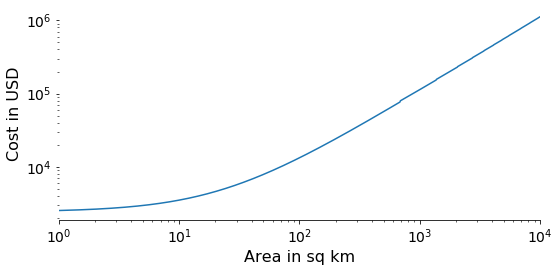

In [20]:
# Plot the single cost curve for a given resolution of 0.03m
f = plt.figure(figsize=(8, 4))
plt.plot(area_list, cost_mat_all[:, np.argmax(resolution_list==0.03)])
# plt.plot(area_list, hotel_cost_mat_percent[:, np.argmax(resolution_list==0.03)]) # Plot the hotel percentage
plt.xscale('log')
plt.yscale('log')
# plt.grid(alpha=0.7)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlim([1, 1e4+1])
plt.xlabel('Area in sq km')
plt.ylabel('Cost in USD')#,labelpad=5)
plt.tight_layout()
plt.savefig('total_price.png', dpi=300, transparent=True)

### The hotel cost percentage plot

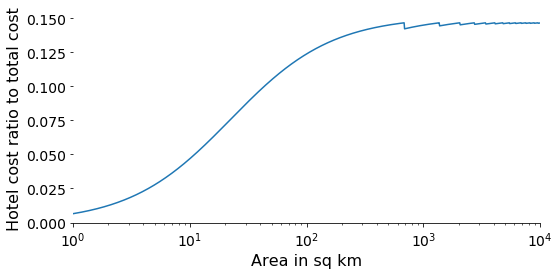

In [21]:
# Plot the single cost curve for a given resolution of 0.03m
f = plt.figure(figsize=(8, 4))
# plt.plot(area_list, cost_mat_all[:, np.argmax(resolution_list==0.03)])
plt.plot(area_list, hotel_cost_mat_percent[:, np.argmax(resolution_list==0.03)]) # Plot the hotel percentage
plt.xscale('log')
# plt.yscale('log')
# plt.grid(alpha=0.7)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlim([1, 1e4])
plt.xlabel('Area in sq km')
plt.ylabel('Hotel cost ratio to total cost')#,labelpad=5)
plt.tight_layout()
plt.savefig('hotel_cost_percentage.png', dpi=300, transparent=True)

### The satellite data part

In [13]:
# Satellite part
import pandas as pd
df = pd.read_csv('sat_price.csv')
df
#print(df['Resolution (m)'])

,Satellite name,Company name,Resolution (m),Spectra,Price_low,Price_high,Smallest area,source
0,QuickBird,DigitalGlobe,0.610,pan,17.00,23.00,25.0,https://www.aaas.org/resources/high-resolution...
1,WV-1/2,DigitalGlobe,0.500,pan,14.00,23.00,25.0,https://www.aaas.org/resources/high-resolution...
2,WV-3,Maxar,0.310,pan,23.00,50.00,25.0,https://apollomapping.com/worldview-3-satellit...
3,EROS-B,ImageSat Int,0.700,pan,13.00,25.00,50.0,https://www.aaas.org/resources/high-resolution...
4,IKONOS,GeoEye,0.820,pan,10.00,20.00,50.0,https://www.aaas.org/resources/high-resolution...
5,GeoEye-1,GeoEye,0.410,pan,10.00,14.00,50.0,https://www.aaas.org/resources/high-resolution...
6,Pleiades,AIRBUS,0.510,all band,13.00,21.00,25.0,Airbus_defence_space
7,SPOT6&7,AIRBUS,1.500,pan,4.75,5.25,100.0,Airbus_defence_space
8,HxGN*,Hexagon,0.150,RGB,6.80,6.80,NaN,https://services.hxgncontent.com/admin/shop.do...
9,Com*,NC,0.300,NaN,96.00,96.00,NaN,https://files.nc.gov/ncdit/documents/files/Ort...


### The drone price part

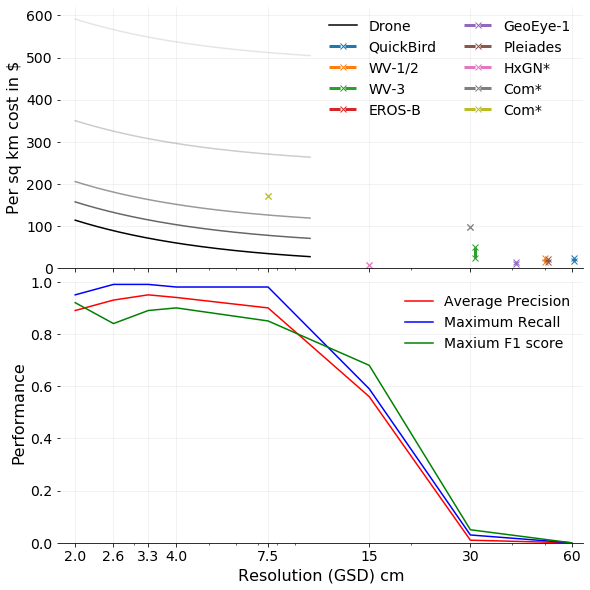

In [14]:
#print(np.shape(cost_mat))
#print(area_list)
res_list = np.array([0.02, 0.026, 0.033, 0.04, 0.075,  0.15, 0.3, 0.6])
res_list_cm = res_list * 100
res_list_name = res_list_cm.astype('str')
res_list_name[2] = '3.3'
res_list_name[5] = '15'
res_list_name[6] = '30'
res_list_name[7] = '60'
color_g=np.array([1, 0.8,  0.6, 0.4, 0.2, 0.1])[::-1]
f = plt.figure(figsize=[8,8])
ax1 = plt.subplot(211)
# Plot the price list as function of area
plt.plot(resolution_list*100, cost_mat[-1, :], c='k', alpha=color_g[-1],label='Drone')
for i in range(0, len(area_list)-1):
    plt.plot(resolution_list*100, cost_mat[i, :], c='k', alpha=color_g[i])#, label='{}km^2'.format(area_list[i]))
# Plot the company price for satellite data
for i in range(len(df)):
    if df['Resolution (m)'][i] < 0.8:
        plt.plot([df['Resolution (m)'][i]*100,df['Resolution (m)'][i]*100], 
                 [df['Price_low'][i], df['Price_high'][i]], 
                 'x--',label=df['Satellite name'][i],
                lw=3)
        #print(df['Resolution (m)'][i])

plt.legend(frameon=False,ncol=2)
# plt.ylim([0, 1])
#plt.xlim([0.018, 0.65])
plt.ylabel('Per sq km cost in $')
plt.grid(alpha=0.2)
plt.gca().set_ylim(bottom=0)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.yscale('log')
plt.xticks(res_list, res_list_name)
import matplotlib
# Hard coded from previous results
AP_list = [0.89, 0.93, 0.95, 0.94 , 0.90 ,0.56 , 0.01, 0]
R_max_list = [0.95, 0.99, 0.99, 0.98, 0.98, 0.59, 0.03, 0]
F1_list = [0.92, 0.84, 0.89, 0.90, 0.85, 0.68, 0.05, 0]
res_list *= 100
res_list_extra = np.array([0.3, 0.6])*100
AP_extra, R_max_extra, F1_extra = [0.01, 0],[0.03, 0],[0.05, 0]
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 12}

# matplotlib.rc('font', **font)
ax2 = plt.subplot(212, sharex = ax1)
plt.plot(res_list_cm, AP_list, '-',c='red', label='Average Precision')
plt.plot(res_list_cm, R_max_list, '-',c='blue', label='Maximum Recall')
plt.plot(res_list_cm, F1_list, '-',c='green', label='Maxium F1 score')
# plt.plot(res_list[:-1], AP_list, '-',c='red', label='Average Precision')
# plt.plot(res_list[:-1], R_max_list, '-',c='blue', label='Maximum Recall')
# plt.plot(res_list[:-1], F1_list, '-',c='green', label='Maxium F1 score')
# # Extra levels of 
# plt.plot(res_list_extra, AP_extra, '-',c='red')
# plt.plot(res_list_extra, R_max_extra, '-',c='blue')
# plt.plot(res_list_extra, F1_extra, '-',c='green')
plt.legend(frameon=False)
plt.ylabel('Performance')
plt.xscale('log')
plt.xticks(res_list, res_list_name)
#plt.xticks(res_list, res_list)
plt.xlabel('Resolution (GSD) cm')
plt.xlim([1.8, 65])
plt.ylim([0, 1])
plt.grid(alpha=0.2)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax1.get_shared_x_axes().join(ax1, ax2)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout(pad=0)

plt.savefig('cost_estimation.png',dpi=300,transparent=True)